In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu

In [13]:
df = pd.read_csv(r"C:\Users\ruben\OneDrive\Desktop\Loan approvval\credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [14]:
df.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [15]:
categorical_columns = df.select_dtypes(include="object").columns

for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")

# perform WoE encoding for person_home_ownership, loan_intent, loan_grade
# perform binary mapping for cb_person_default_on_file

person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file: ['Y' 'N']


In [16]:
df["person_emp_length"] = df["person_emp_length"].fillna(df["person_emp_length"].median())
df["person_emp_length"].describe()

count    32581.000000
mean         4.767994
std          4.087372
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

In [22]:
median_value = df["person_emp_length"].median()
df.loc[df["person_emp_length"] > 60, "person_emp_length"] = median_value

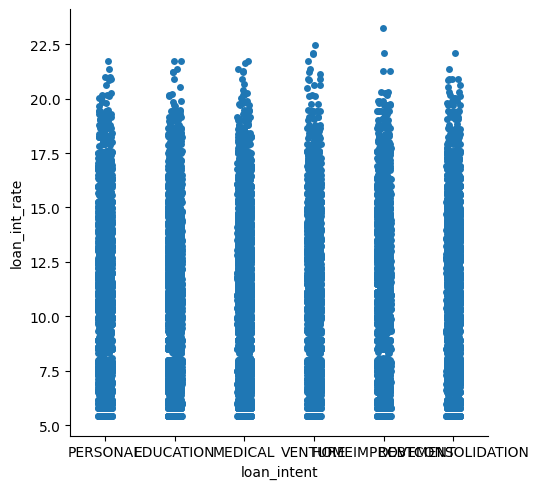

In [31]:
sns.catplot(x="loan_intent", y="loan_int_rate", data=df)

In [52]:
# Create a crosstab and sort by a specific loan_status column
crosstab = pd.crosstab(df["loan_grade"], df["loan_status"], normalize="index")
crosstab

loan_status,0,1
loan_grade,,
A,0.900436,0.099564
B,0.837240,0.162760
C,0.792660,0.207340
D,0.409542,0.590458
E,0.355809,0.644191
F,0.294606,0.705394
G,0.015625,0.984375


In [61]:
df[df["loan_grade"]=="F"].value_counts(df["loan_status"])

loan_status
1    170
0     71
Name: count, dtype: int64

<Axes: xlabel='loan_status', ylabel='loan_grade'>

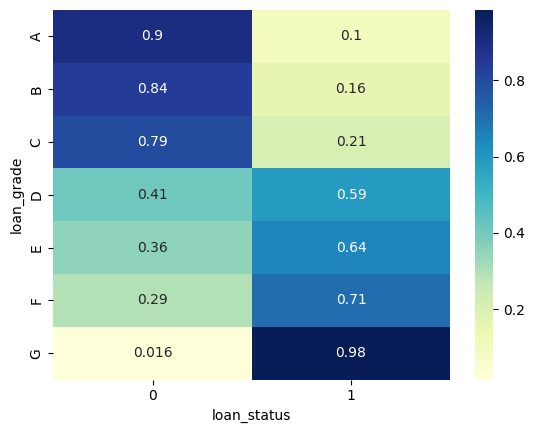

In [53]:
sns.heatmap(crosstab, annot=True, cmap="YlGnBu")

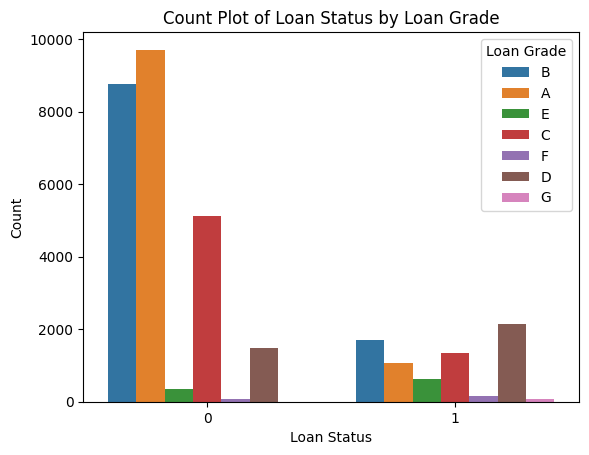

In [56]:
sns.countplot(data=df, x="loan_status", hue="loan_grade")
plt.title("Count Plot of Loan Status by Loan Grade")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.legend(title="Loan Grade")
plt.show()

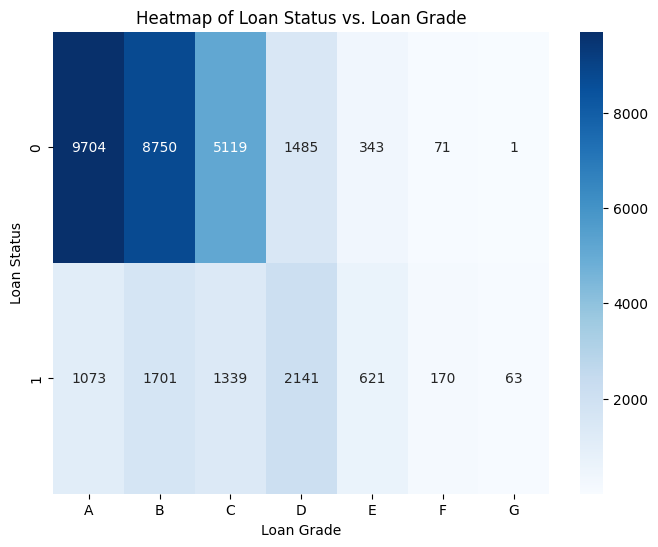

In [59]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create a crosstab of counts
crosstab = pd.crosstab(df["loan_status"], df["loan_grade"])

# Plot a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt="d", cmap="Blues")
plt.title("Heatmap of Loan Status vs. Loan Grade")
plt.xlabel("Loan Grade")
plt.ylabel("Loan Status")
plt.show()

In [27]:
df[df["loan_int_rate"].isna()]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
39,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.42,N,4
50,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,NaN,1,0.38,Y,4
57,23,277000,OWN,3.0,PERSONAL,A,35000,NaN,0,0.13,N,4
59,24,12000,OWN,2.0,VENTURE,E,1750,NaN,0,0.15,Y,3
62,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,NaN,1,0.04,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32547,53,4888,OWN,0.0,VENTURE,C,1400,NaN,1,0.29,Y,28
32552,65,45900,RENT,2.0,EDUCATION,C,10000,NaN,0,0.22,Y,19
32553,54,20000,RENT,2.0,MEDICAL,C,5000,NaN,0,0.25,N,28
32569,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,NaN,0,0.13,N,23


<Axes: xlabel='person_emp_length', ylabel='loan_int_rate'>

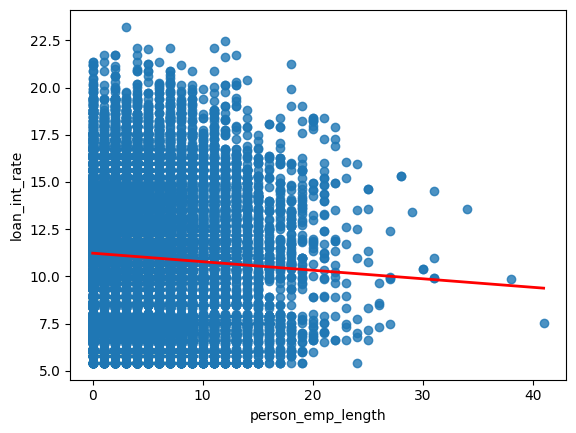

In [25]:
sns.regplot(x="person_emp_length", y="loan_int_rate", data=df, line_kws={'color': 'red', 'linewidth': 2}, ci=None)

<Axes: xlabel='loan_int_rate', ylabel='Count'>

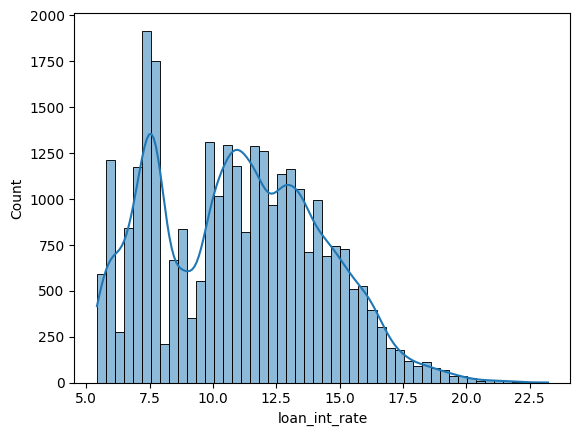

In [17]:
df[df["loan_int_rate"].isna()]
sns.histplot(df["loan_int_rate"], kde=True, bins=50)

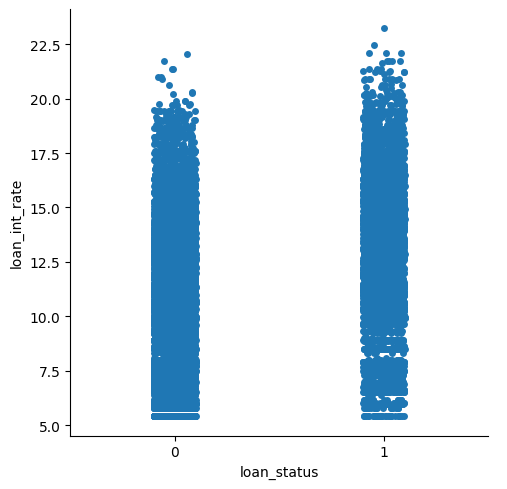

In [18]:
sns.catplot(data=df, x="loan_status", y="loan_int_rate")

In [25]:
df.groupby("loan_status")["loan_int_rate"].agg(['min', 'mean', 'median', 'max'])

,min,mean,median,max
loan_status,,,,
0,5.42,10.435999,10.59,22.06
1,5.42,13.060207,13.49,23.22


In [26]:
import pandas as pd
from scipy.stats import ttest_ind, levene, mannwhitneyu
import matplotlib.pyplot as plt
import scipy.stats as stats

# Drop NaN values
group_0 = df[df["loan_status"] == 0]["loan_int_rate"].dropna()
group_1 = df[df["loan_status"] == 1]["loan_int_rate"].dropna()

# Check equal variance
stat, p_value_var = levene(group_0, group_1)
print(f"Levene's test: statistic = {stat:.4f}, p-value = {p_value_var:.4f}")

# Perform t-test or Mann-Whitney U test
if p_value_var > 0.05:  # Equal variances
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=True)
else:  # Unequal variances (Welch's t-test)
    t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Non-parametric test if necessary
if p_value < 0.05:  # If t-test shows significance
    u_stat, p_value_mwu = mannwhitneyu(group_0, group_1)
    print(f"Mann-Whitney U test: U-statistic = {u_stat:.4f}, p-value = {p_value_mwu:.4f}")


Levene's test: statistic = 66.9625, p-value = 0.0000
T-test: t-statistic = -57.7566, p-value = 0.0000
Mann-Whitney U test: U-statistic = 41146343.5000, p-value = 0.0000
